In [206]:
# Preamble
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as scipy
from scipy import stats
import collections
import operator

import sklearn
from sklearn.utils import resample
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE

import plotly
import plotly.plotly as py
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

from functools import reduce

import geopandas as gp
#import pyshp
import shapely

#from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [207]:
# Importing the main datafile
data = pd.read_csv("kaggle_internet.csv")

In [208]:
# Peak at the data
data.head()

,county,state,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet
0,Anchorage Municipality,AK,05000US02020,-149.274354,61.177549,298192,184841.0,16102.0,27142.0,23916.0,7669.0,7935.0,2234.0,8196.0,44804.0,66162.0,70713.0,18302,33.0,0.4018,85634,28.0,6.593887
1,Fairbanks North Star Borough,AK,05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,2357.0,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,77328,25.6,12.102458
2,Matanuska-Susitna Borough,AK,05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,325.0,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,69332,29.6,11.156575
3,Baldwin County,AL,05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,1469.0,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,56732,29.3,17.868167
4,Calhoun County,AL,05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,NaN,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,41687,24.8,23.464932


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 23 columns):
county                      820 non-null object
state                       820 non-null object
GEOID                       820 non-null object
lon                         820 non-null float64
lat                         820 non-null float64
P_total                     820 non-null int64
P_white                     607 non-null float64
P_black                     607 non-null float64
P_asian                     607 non-null float64
P_native                    607 non-null float64
P_hawaiian                  607 non-null float64
P_others                    607 non-null float64
P_below_middle_school       818 non-null float64
P_some_high_school          818 non-null float64
P_high_school_equivalent    818 non-null float64
P_some_college              818 non-null float64
P_bachelor_and_above        818 non-null float64
P_below_poverty             820 non-null int64
median_age          

In [210]:
# Importing data for regional distinction (e.g. West, South, etc.) -- to be merged with the main dataframe
#https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv
states_regions_divisions = pd.read_csv("https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv")
states_regions_divisions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [211]:
# Adding regions to the main dataframe
states_regions_divisions.columns = ['state_name','state_code','region','division']
data = data.rename(columns={'state': 'state_code'})
data = pd.merge(data, states_regions_divisions, on='state_code')

In [212]:
'''
Importing data on additional socio-demographic attributes:
    - % of people with disability per county
    - % of native vs foreign-born population per county
    - employment status (i.e. employment & unemployment rate)
    - share of male-female population
'''
disability = pd.read_csv("disability.csv", encoding='latin-1')
native_foreign = pd.read_csv("native_foreign.csv", encoding='latin-1')
employment = pd.read_csv("employment.csv", encoding='latin-1')
sex = pd.read_csv("sex_age.csv", encoding='latin-1')

In [213]:
disability['with_disability']=disability['Percent with a disability; Estimate; Total civilian noninstitutionalized population']/100
disability = disability[['Id','with_disability']]
disability.head()

,Id,with_disability
0,0500000US01003,0.149
1,0500000US01015,0.215
2,0500000US01043,0.156
3,0500000US01049,0.129
4,0500000US01051,0.172


In [214]:
employment[['Employment/Population Ratio; Estimate; Population 16 years and over','Unemployment rate; Estimate; Population 16 years and over']] = employment[['Employment/Population Ratio; Estimate; Population 16 years and over','Unemployment rate; Estimate; Population 16 years and over']].apply(pd.to_numeric, errors='coerce')

employment['employment_rate'] = employment['Employment/Population Ratio; Estimate; Population 16 years and over']/100
employment['unemployment_rate'] = employment['Unemployment rate; Estimate; Population 16 years and over']/100

employment = employment[['Id','employment_rate','unemployment_rate']]
employment.head()

,Id,employment_rate,unemployment_rate
0,0500000US01003,0.536,0.036
1,0500000US01015,0.504,0.093
2,0500000US01043,0.490,0.047
3,0500000US01049,0.527,0.050
4,0500000US01051,0.522,0.049


In [215]:
sex['male'] = sex['Male; Estimate; Total population'] / sex['Total; Estimate; Total population']
sex['female'] = sex['Female; Estimate; Total population'] / sex['Total; Estimate; Total population']
sex = sex[['Id','male','female']]
sex.head()

,Id,male,female
0,0500000US01003,0.483796,0.516204
1,0500000US01015,0.484168,0.515832
2,0500000US01043,0.493495,0.506505
3,0500000US01049,0.486728,0.513272
4,0500000US01051,0.488466,0.511534


In [216]:
native_foreign['native_p_per'] = native_foreign['Estimate; Total: - Native'] / native_foreign['Estimate; Total:']
native_foreign['foreign_born_p_per'] = native_foreign['Estimate; Total: - Foreign-Born'] / native_foreign['Estimate; Total:']

native_foreign = native_foreign[['Id','native_p_per','foreign_born_p_per']]
native_foreign.head()

,Id,native_p_per,foreign_born_p_per
0,0500000US01003,0.978213,0.021787
1,0500000US01015,0.975953,0.024047
2,0500000US01043,0.967758,0.032242
3,0500000US01049,0.945106,0.054894
4,0500000US01051,0.991614,0.008386


In [217]:
demographics = [disability, employment, sex, native_foreign]
demographics_final = reduce(lambda left,right: pd.merge(left,right,on='Id'), demographics)
demographics_final.head()

,Id,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per
0,0500000US01003,0.149,0.536,0.036,0.483796,0.516204,0.978213,0.021787
1,0500000US01015,0.215,0.504,0.093,0.484168,0.515832,0.975953,0.024047
2,0500000US01043,0.156,0.490,0.047,0.493495,0.506505,0.967758,0.032242
3,0500000US01049,0.129,0.527,0.050,0.486728,0.513272,0.945106,0.054894
4,0500000US01051,0.172,0.522,0.049,0.488466,0.511534,0.991614,0.008386


In [218]:
# Creating a unique identifier in the main dataframe in order to merge it with demographics_final
data[['Id', 'Id2']] = data['GEOID'].str.split('05000US', expand=True)
data = data.drop('Id',axis=1)
demographics_final[['Id','Id2']] = demographics_final['Id'].str.split('0500000US', expand=True)
demographics_final = demographics_final.drop('Id',axis=1)

In [219]:
data['Id2'] = data['Id2'].astype(str)
demographics_final['Id2'] = demographics_final['Id2'].astype(str)

# Create a "master" dataframe with original & new socio-demographic data
master = pd.merge(data, demographics_final, on='Id2',how="right")
master.head()

,county,state_code,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,state_name,region,division,Id2,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per
0,Anchorage Municipality,AK,05000US02020,-149.274354,61.177549,298192,184841.0,16102.0,27142.0,23916.0,7669.0,7935.0,2234.0,8196.0,44804.0,66162.0,70713.0,18302,33.0,0.4018,85634,28.0,6.593887,Alaska,West,Pacific,02020,0.119,0.662,0.052,0.512697,0.487303,0.897486,0.102514
1,Fairbanks North Star Borough,AK,05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,2357.0,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,77328,25.6,12.102458,Alaska,West,Pacific,02090,0.097,0.611,0.103,0.553163,0.446837,0.941315,0.058685
2,Matanuska-Susitna Borough,AK,05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,325.0,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,69332,29.6,11.156575,Alaska,West,Pacific,02170,0.128,0.558,0.132,0.519897,0.480103,0.965860,0.034140
3,Baldwin County,AL,05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,1469.0,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,56732,29.3,17.868167,Alabama,South,East South Central,01003,0.149,0.536,0.036,0.483796,0.516204,0.978213,0.021787
4,Calhoun County,AL,05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,NaN,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,41687,24.8,23.464932,Alabama,South,East South Central,01015,0.215,0.504,0.093,0.484168,0.515832,0.975953,0.024047


In [220]:
# Transform population metrics into a normalised scale (0-1)

#what to do about missing values?

# Ethnicity:
master['ethnicity'] = master['P_white']+master['P_black']+master['P_asian']+master['P_native']+master['P_hawaiian']+master['P_others']
master['white_per'] = master['P_white'] / master['ethnicity']
master['black_per'] = master['P_black'] / master['ethnicity']
master['asian_per'] = master['P_asian'] / master['ethnicity']
master['native_per'] = master['P_native'] / master['ethnicity']
master['hawaiian_per'] = master['P_hawaiian'] / master['ethnicity']
master['others_per'] = master['P_others'] / master['ethnicity']

# Education:
master['edu'] = (master['P_below_middle_school'] + master['P_some_high_school'] + 
                 master['P_high_school_equivalent'] + master['P_some_college'] + master['P_bachelor_and_above'])
master['below_middle_school_per'] = master['P_below_middle_school'] / master['edu']
master['some_high_school_per'] = master['P_some_high_school'] / master['edu']
master['high_school_per'] = master['P_high_school_equivalent'] / master['edu']
master['some_college_per'] = master['P_some_college'] / master['edu']
master['bachelor_and_above_per'] = master['P_bachelor_and_above'] / master['edu']

master['below_poverty_per'] = master['P_below_poverty']/master['P_total']


In [221]:
master['education_level'] = ((master['below_middle_school_per']*1)+
                             (master['some_high_school_per']*2)+
                             (master['high_school_per']*3)+
                             (master['some_college_per']*4)+
                             (master['bachelor_and_above_per']*5))

In [222]:
# Transforming the attribute 'percent_no_internet' to a 0-1 scale
master['percent_no_internet'] = master['percent_no_internet'] / 100

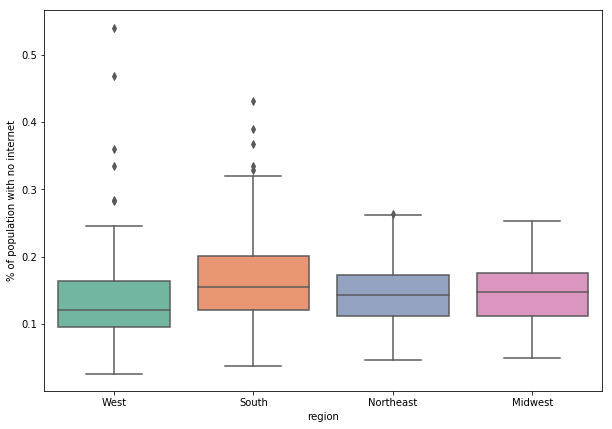

In [223]:
plt.figure(figsize=(10,7))
sns.boxplot(x="region", y="percent_no_internet", data=master, palette="Set2")

plt.ylabel('% of population with no internet')

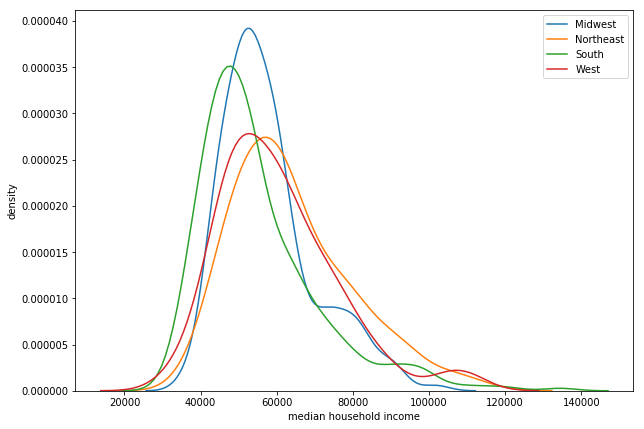

In [224]:
# Density plot of median household income
plt.figure(figsize=(10,7))

regions = master.groupby('region').median_household_income
for label, arr in regions:
    sns.kdeplot(arr, label=label)
    
plt.xlabel('median household income')
plt.ylabel('density')

In [225]:
print(f'US-wide share of people without internet (median): {np.median(master.percent_no_internet)}')

US-wide share of people without internet (median): 0.147109080200064


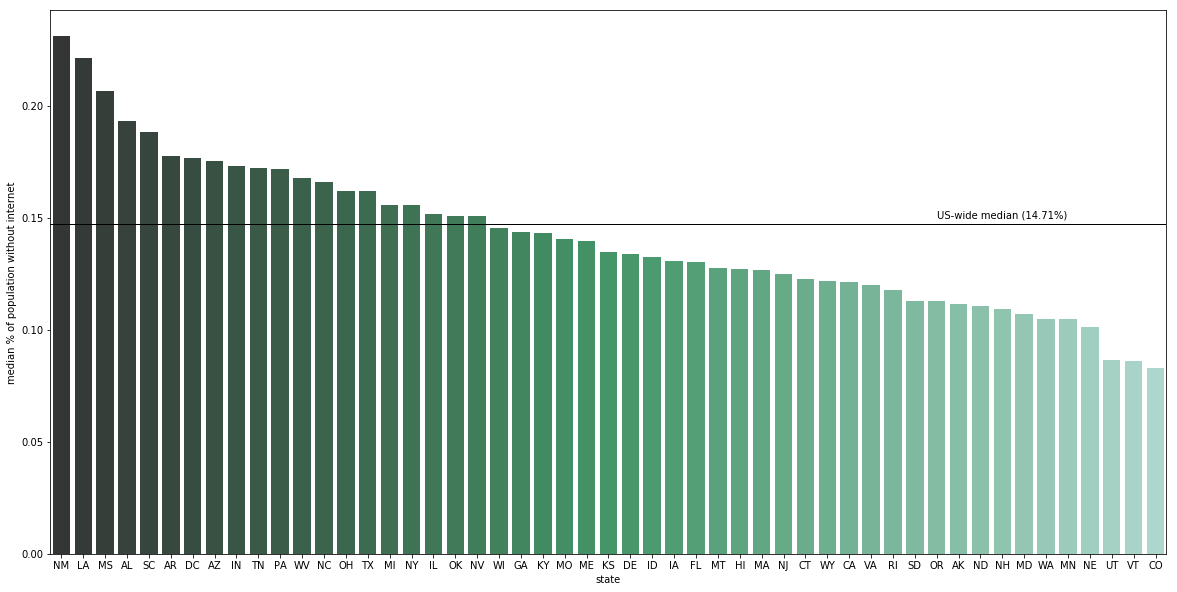

In [226]:
plt.figure(figsize=(20,10))

no_internet_state = master.groupby(['state_code'])[['percent_no_internet']].median()
no_internet_state.columns = ['state_median_no_net']
no_internet_state = no_internet_state.reset_index().sort_values(by=['state_median_no_net'], ascending=False)

sns.barplot(x ='state_code', y='state_median_no_net',data = no_internet_state,palette="BuGn_d")
plt.axhline(master.percent_no_internet.median(), color='black',linewidth=1)
plt.annotate('US-wide median (14.71%)', xy=(40, 0.15))

plt.xlabel('state')
plt.ylabel('median % of population without internet')

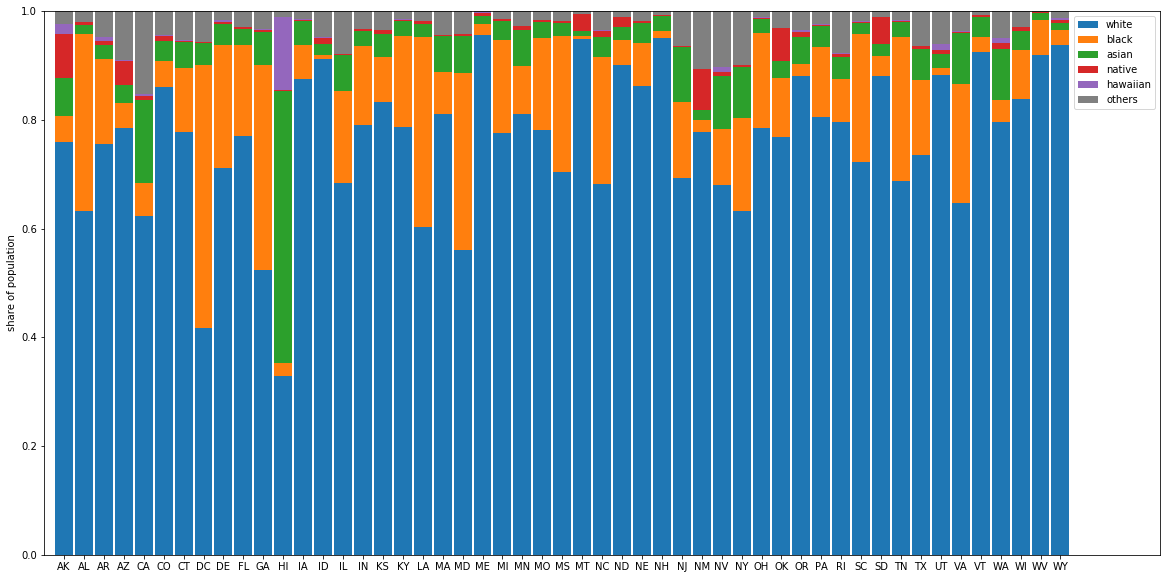

In [227]:
state_ethnic = master.groupby(['state_code'])[['P_white','P_black',
                                               'P_asian','P_native',
                                              'P_hawaiian','P_others','ethnicity']].sum()
state_ethnic['white_per'] = state_ethnic['P_white'] / state_ethnic['ethnicity']
state_ethnic['black_per'] = state_ethnic['P_black'] / state_ethnic['ethnicity']
state_ethnic['asian_per'] = state_ethnic['P_asian'] / state_ethnic['ethnicity']
state_ethnic['native_per'] = state_ethnic['P_native'] / state_ethnic['ethnicity']
state_ethnic['hawaiian_per'] = state_ethnic['P_hawaiian'] / state_ethnic['ethnicity']
state_ethnic['others_per'] = state_ethnic['P_others'] / state_ethnic['ethnicity']

state_ethnic = state_ethnic.reset_index()

plt.figure(figsize=(20,10))
configs = state_ethnic['state_code']
N = len(configs)
ind = np.arange(N)
width = 0.9

dataset1 = np.array(state_ethnic.white_per)
dataset2 = np.array(state_ethnic.black_per)
dataset3 = np.array(state_ethnic.asian_per)
dataset4 = np.array(state_ethnic.native_per)
dataset5 = np.array(state_ethnic.hawaiian_per)
dataset6 = np.array(state_ethnic.others_per)

p1 = plt.bar(ind, dataset1, width)
p2 = plt.bar(ind, dataset2, width,  bottom=dataset1)
p3 = plt.bar(ind, dataset3, width,  bottom=dataset1+dataset2)
p4 = plt.bar(ind, dataset4, width,  bottom=dataset1+dataset2+dataset3)
p5 = plt.bar(ind, dataset5, width,  bottom=dataset1+dataset2+dataset3+dataset4)
p6 = plt.bar(ind, dataset6, width,  bottom=dataset1+dataset2+dataset3+dataset4+dataset5,color="gray")

plt.ylim(0,1)
plt.xlim(-1,55)
plt.ylabel('share of population')
plt.xticks(ind, configs)
plt.legend((p1[0], p2[0], p3[0], p4[0],p5[0],p6[0]), ('white', 'black','asian','native','hawaiian','others'))

In [228]:
# Adding average state "net-disconnectivity" rate:
master = pd.merge(master, no_internet_state, on='state_code',how="right")

In [229]:
# Create income categories according to:
# https://www.statista.com/statistics/203183/percentage-distribution-of-household-income-in-the-us/

master['under_15000']=0
master['under_15000'][(master['median_household_income'] >= 0) & (master['median_household_income'] <= 14999)]=1

master['15000_24999']=0
master['15000_24999'][(master['median_household_income'] >= 15000) & (master['median_household_income'] <= 24999)]=1

master['25000_34999']=0
master['25000_34999'][(master['median_household_income'] >= 25000) & (master['median_household_income'] <= 34999)]=1

master['35000_49999']=0
master['35000_49999'][(master['median_household_income'] >= 35000) & (master['median_household_income'] <= 49999)]=1

master['50000_74999']=0
master['50000_74999'][(master['median_household_income'] >= 50000) & (master['median_household_income'] <= 74999)]=1

master['75000_99999']=0
master['75000_99999'][(master['median_household_income'] >= 75000) & (master['median_household_income'] <= 99999)]=1

master['100000_149999']=0
master['100000_149999'][(master['median_household_income'] >= 100000) & (master['median_household_income'] <= 149999)]=1

master['150000_199999']=0
master['150000_199999'][(master['median_household_income'] >= 150000) & (master['median_household_income'] <= 199999)]=1

master['200000_and_over']=0
master['200000_and_over'][(master['median_household_income'] >= 200000)]=1

In [230]:
state_income_class = master.groupby('state_code').agg({'under_15000':'sum',
                                                      '15000_24999':'sum',
                                                      '25000_34999':'sum',
                                                      '35000_49999':'sum',
                                                      '50000_74999':'sum',
                                                      '75000_99999':'sum',
                                                      '100000_149999':'sum',
                                                      '150000_199999':'sum',
                                                      '200000_and_over':'sum'})

state_income_class.sum()

under_15000          0
15000_24999          0
25000_34999          6
35000_49999        267
50000_74999        435
75000_99999         96
100000_149999       16
150000_199999        0
200000_and_over      0
dtype: int64

In [231]:
# No counties with median income below 25000 or above 150000
# therefore, drop [under_15000, 15000_24999, 150000_199999, 200000_and_over]

state_income_class = state_income_class.drop(['under_15000','15000_24999',
                                              '150000_199999', '200000_and_over'],axis=1)

master = master.drop(['under_15000','15000_24999', '150000_199999', '200000_and_over'],axis=1)

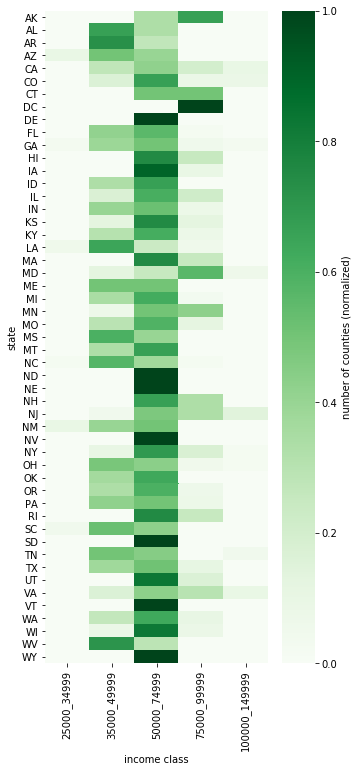

In [232]:
plt.figure(figsize=(5,12))
state_income_class = state_income_class.div(state_income_class.sum(axis=1), axis=0)
sns.heatmap(state_income_class, cmap='Greens',cbar_kws={'label': 'number of counties (normalized)'})
plt.xlabel('income class')
plt.xticks(rotation=90)
plt.ylabel('state')

In [311]:
master['text'] = master['county'] + ' (' + master['state_name'] + ')' + ': ' + round((master['percent_no_internet']*100),2).astype(str) + "%"

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = master['lon'],
        lat = master['lat'],
        text = master['text'],
        hoverinfo = 'text',
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = True,
            symbol = 'round',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Reds',
            cmin = 0,
            color = master['percent_no_internet'],
            cmax = master['percent_no_internet'].max(),
            colorbar=dict(
                title="% no internet"
            )
        ))]

layout = dict(
        title = 'Percentage of people without internet in counties with over 65,000 inhabitants<br>(Hover for county names)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False)

In [236]:
no_internet_state['text'] = no_internet_state['state_code'] + ': ' + round((no_internet_state['state_median_no_net']*100),2).astype(str) + "%"

data1 = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = no_internet_state['state_code'].tolist(),
        z = no_internet_state['state_median_no_net'].tolist(),
        text = no_internet_state['text'],
        hoverinfo = 'text',
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "median %")
        ) ]
   
layout = dict(
        title = 'Percentage of population without internet<br>(Hover for detailed information)',
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),),
             )

fig = dict(data=data1, layout=layout)
py.iplot(fig)

In [237]:
threshold_national = master.percent_no_internet.median()

# Creating dependent variables for the model:
master['no_net_over_state_level'] = 0
master['no_net_over_state_level'][(master['percent_no_internet'] > master['state_median_no_net'])] = 1
master['no_net_over_national_level'] = 0
master['no_net_over_national_level'][(master['percent_no_internet'] > threshold_national)] = 1

In [238]:
master.no_net_over_state_level.value_counts()

0    422
1    398
Name: no_net_over_state_level, dtype: int64

In [239]:
master.no_net_over_national_level.value_counts()

1    410
0    410
Name: no_net_over_national_level, dtype: int64

In [240]:
correlations = master.corr()
correlations

,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per,ethnicity,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,edu,below_middle_school_per,some_high_school_per,high_school_per,some_college_per,bachelor_and_above_per,below_poverty_per,education_level,state_median_no_net,25000_34999,35000_49999,50000_74999,75000_99999,100000_149999,no_net_over_state_level,no_net_over_national_level
lon,1.000000,-0.054320,-0.104168,-0.068606,0.132779,-0.168883,-0.280450,-0.375879,-0.124056,-0.137603,-0.096755,-0.047241,-0.146114,-0.075354,-0.099790,0.243585,0.006900,0.000627,-0.060051,0.076285,0.044267,0.036360,-0.104425,-0.288725,0.288725,0.186654,-0.186654,-0.068081,0.013124,0.343773,-0.307306,-0.185861,-0.406672,-0.288274,-0.097653,-0.299962,0.002028,0.275864,-0.416317,0.080583,-0.079380,0.045992,0.244896,-0.013421,0.020769,-0.032506,0.028346,-0.010692,-0.000220,0.090936
lat,-0.054320,1.000000,-0.081087,-0.115944,-0.157080,-0.071740,-0.067080,-0.165592,-0.071789,-0.105721,-0.126938,-0.089206,-0.089257,-0.036896,-0.117663,0.009124,-0.220039,0.215803,-0.158108,-0.233225,-0.144388,0.327792,-0.161157,0.206746,-0.206746,0.141030,-0.141030,-0.123532,0.357106,-0.327458,-0.123880,-0.005796,-0.227768,-0.057513,-0.077424,-0.278107,-0.380461,-0.026723,0.038572,0.169131,-0.284644,0.266277,-0.376769,-0.068175,-0.206155,0.116476,0.130283,0.017341,-0.018992,-0.151069
P_total,-0.104168,-0.081087,1.000000,0.971922,0.747189,0.838708,0.521726,0.340207,0.855374,0.911578,0.966224,0.977597,0.988319,0.961460,0.962629,-0.115311,0.225810,0.172653,0.155607,-0.153540,-0.261809,0.163468,0.005464,-0.093875,0.093875,-0.552827,0.552827,0.999819,-0.317735,0.124392,0.333877,-0.066939,0.008908,0.337359,0.998846,0.303865,-0.055461,-0.279501,-0.204664,0.230034,0.001028,0.107341,-0.101675,-0.034751,-0.150512,0.070748,0.094048,0.057453,-0.054508,-0.131034
P_white,-0.068606,-0.115944,0.971922,1.000000,0.664573,0.745596,0.518515,0.289749,0.763149,0.844091,0.914558,0.951750,0.974050,0.935758,0.913047,-0.053713,0.231168,0.162942,0.151586,-0.144966,-0.262778,0.165141,-0.011932,-0.106968,0.106968,-0.502951,0.502951,0.972923,-0.200298,0.040272,0.272110,-0.082724,-0.022891,0.285313,0.970485,0.288654,-0.027720,-0.258950,-0.217066,0.209326,-0.022363,0.083983,-0.073632,-0.044100,-0.153742,0.066600,0.098509,0.033041,-0.055482,-0.123896
P_black,0.132779,-0.157080,0.747189,0.664573,1.000000,0.498853,0.254333,0.109936,0.530272,0.607151,0.747170,0.781068,0.714326,0.711801,0.786508,-0.135321,0.367019,-0.020654,0.163333,0.040852,-0.158127,0.095998,0.138867,-0.288473,0.288473,-0.419840,0.419840,0.751101,-0.544993,0.524168,0.176098,-0.075256,-0.045080,0.215491,0.745206,0.216806,0.107834,-0.158880,-0.249171,0.145309,0.184148,0.017453,0.061797,-0.020317,-0.009467,0.018777,0.000636,-0.025023,0.047797,0.043310
P_asian,-0.168883,-0.071740,0.838708,0.745596,0.498853,1.000000,0.415273,0.490670,0.820922,0.847392,0.801515,0.770177,0.803109,0.856748,0.767018,-0.071212,0.154280,0.250282,0.118461,-0.144779,-0.257480,0.134937,-0.011597,-0.024153,0.024153,-0.545781,0.545781,0.833139,-0.329803,0.021025,0.581087,-0.044490,0.116043,0.310482,0.844609,0.282535,-0.038646,-0.258646,-0.232588,0.220951,-0.048303,0.093850,-0.107843,-0.020149,-0.137720,-0.026042,0.144379,0.172358,-0.047545,-0.120761
P_native,-0.280450,-0.067080,0.521726,0.518515,0.254333,0.415273,1.000000,0.208973,0.507351,0.498016,0.523581,0.491458,0.550494,0.459467,0.529864,-0.135888,0.116599,-0.069212,-0.016019,0.210119,-0.021440,-0.116718,0.206371,0.032142,-0.032142,-0.170627,0.170627,0.519221,-0.258813,-0.065091,0.087586,0.629638,0.007176,0.250875,0.515036,0.231148,0.146205,-0.105474,0.082003,-0.064841,0.214939,-0.109634,0.0

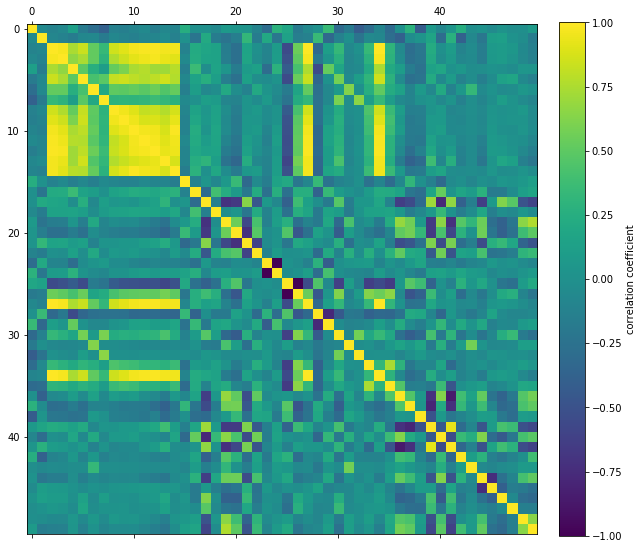

In [241]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax,fraction=0.046, pad=0.04, label='correlation coefficient')

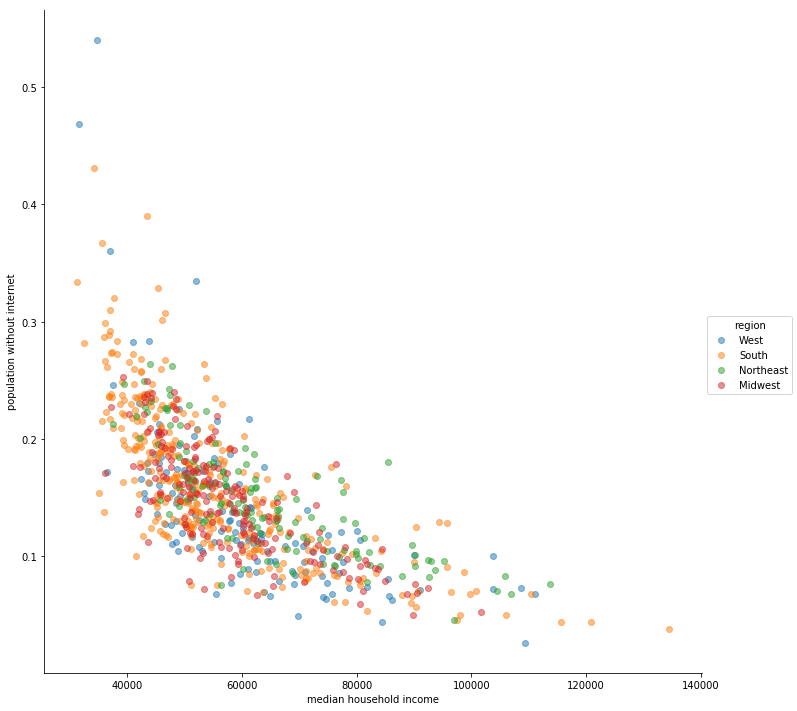

In [242]:
sns.lmplot('median_household_income', 'percent_no_internet', data=master, hue = 'region',
           size=10, fit_reg=False, scatter_kws={'alpha':0.5})
plt.xlabel('median household income')
plt.ylabel('population without internet')

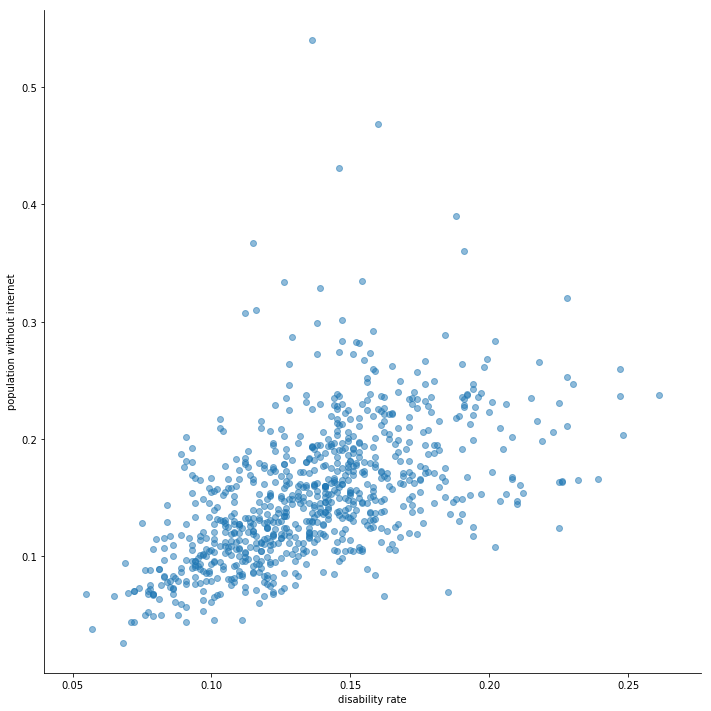

In [243]:
sns.lmplot('with_disability', 'percent_no_internet', data=master,
            size=10, fit_reg=False, scatter_kws={'alpha':0.5})
plt.xlabel('disability rate')
plt.ylabel('population without internet')

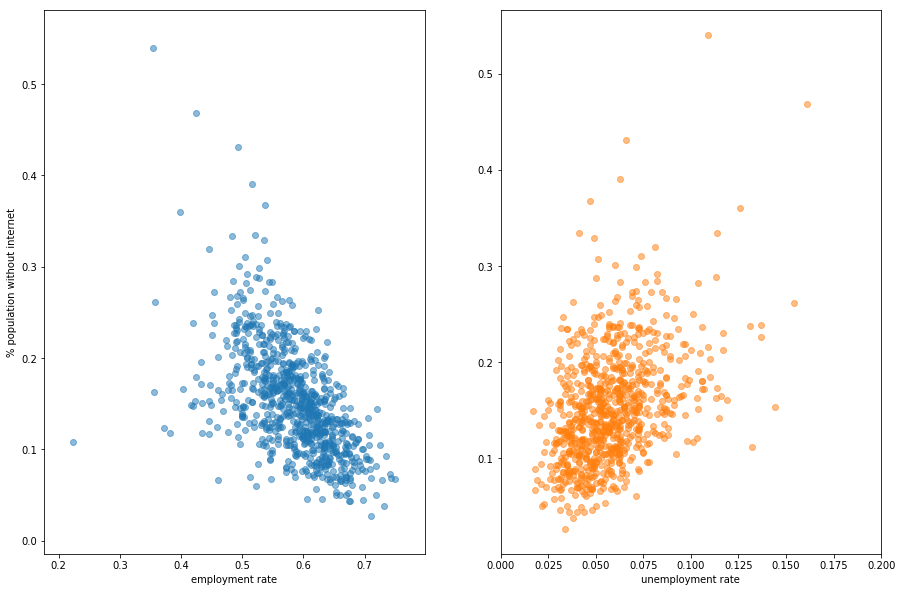

In [244]:
fig_employ, (ax1, ax2) = plt.subplots(ncols=2)
sns.regplot(x=master['employment_rate'], y=master['percent_no_internet'], 
            ax=ax1, fit_reg=False, scatter_kws={'alpha':0.5})
sns.regplot(x=master['unemployment_rate'], y=master['percent_no_internet'],
            ax=ax2, fit_reg=False, scatter_kws={'alpha':0.5})
ax2.set_xlim(0,0.20)
fig_employ.set_figheight(10)
fig_employ.set_figwidth(15)
ax1.set_ylabel('% population without internet')
ax2.set_ylabel('')
ax1.set_xlabel('employment rate')
ax2.set_xlabel('unemployment rate')

In [245]:
master.head()

,county,state_code,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,state_name,region,division,Id2,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per,ethnicity,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,edu,below_middle_school_per,some_high_school_per,high_school_per,some_college_per,bachelor_and_above_per,below_poverty_per,education_level,state_median_no_net,25000_34999,35000_49999,50000_74999,75000_99999,100000_149999,text,no_net_over_state_level,no_net_over_national_level
0,Anchorage Municipality,AK,05000US02020,-149.274354,61.177549,298192,184841.0,16102.0,27142.0,23916.0,7669.0,7935.0,2234.0,8196.0,44804.0,66162.0,70713.0,18302,33.0,0.4018,85634,28.0,0.065939,Alaska,West,Pacific,02020,0.119,0.662,0.052,0.512697,0.487303,0.897486,0.102514,267605.0,0.690723,0.060171,0.101426,0.089371,0.028658,0.029652,192109.0,0.011629,0.042663,0.233222,0.344398,0.368088,0.061377,4.014653,0.111566,0,0,0,1,0,Anchorage Municipality (Alaska): 6.59%,0,0
1,Fairbanks North Star Borough,AK,05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,2357.0,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,77328,25.6,0.121025,Alaska,West,Pacific,02090,0.097,0.611,0.103,0.553163,0.446837,0.941315,0.058685,94048.0,0.802792,0.046625,0.041202,0.078970,0.005348,0.025062,61003.0,0.015147,0.025032,0.241382,0.402767,0.315673,0.095224,3.978788,0.111566,0,0,0,1,0,Fairbanks North Star Borough (Alaska): 12.1%,1,0
2,Matanuska-Susitna Borough,AK,05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,325.0,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,69332,29.6,0.111566,Alaska,West,Pacific,02170,0.128,0.558,0.132,0.519897,0.480103,0.965860,0.034140,94337.0,0.914954,0.010802,0.011480,0.057825,0.001495,0.003445,65476.0,0.005147,0.042076,0.321813,0.434846,0.196118,0.094792,3.774711,0.111566,0,0,1,0,0,Matanuska-Susitna Borough (Alaska): 11.16%,0,0
3,Baldwin County,AL,05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,1469.0,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,56732,29.3,0.178682,Alabama,South,East South Central,01003,0.149,0.536,0.036,0.483796,0.516204,0.978213,0.021787,203071.0,0.888773,0.092682,0.004501,0.006810,0.000000,0.007234,145910.0,0.022240,0.072003,0.286629,0.320677,0.298451,0.112076,3.801097,0.193083,0,0,1,0,0,Baldwin County (Alabama): 17.87%,0,1
4,Calhoun County,AL,05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,NaN,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,41687,24.8,0.234649,Alabama,South,East South Central,01015,0.215,0.504,0.093,0.484168,0.515832,0.975953,0.024047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75603.0,0.032472,0.117099,0.327513,0.352169,0.170747,0.158737,3.511620,0.193083,0,1,0,0,0,Calhoun County (Alabama): 23.46%,1,1


In [246]:
master.describe()

,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per,ethnicity,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,edu,below_middle_school_per,some_high_school_per,high_school_per,some_college_per,bachelor_and_above_per,below_poverty_per,education_level,state_median_no_net,25000_34999,35000_49999,50000_74999,75000_99999,100000_149999,no_net_over_state_level,no_net_over_national_level
count,820.000000,820.000000,8.200000e+02,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,607.000000,6.070000e+02,818.000000,818.000000,8.180000e+02,8.180000e+02,8.180000e+02,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,812.000000,812.000000,820.000000,820.000000,820.000000,820.000000,6.070000e+02,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,8.180000e+02,818.000000,818.000000,818.000000,818.000000,818.000000,820.000000,818.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,-89.828567,38.044369,3.340096e+05,2.886817e+05,5.601865e+04,2.781182e+04,2848.385502,900.958814,2.504326e+04,8811.812958,15426.286064,5.762623e+04,6.489833e+04,7.557799e+04,4.454169e+04,38.662683,0.450951,58111.279268,29.412195,0.152647,0.136462,0.583550,0.057849,0.492811,0.507189,0.918031,0.081969,4.013048e+05,0.793343,0.114772,0.041144,0.012084,0.002261,0.036396,2.223407e+05,0.027324,0.072669,0.293572,0.310229,0.296206,0.133263,3.775325,0.148630,0.007317,0.325610,0.530488,0.117073,0.019512,0.485366,0.500000
std,14.975483,5.186474,5.876550e+05,3.905330e+05,1.164917e+05,9.003984e+04,6987.389347,4563.089789,1.073254e+05,32635.312066,31719.026353,8.910828e+04,1.071153e+05,1.420847e+05,9.100647e+04,4.717491,0.035037,15303.301587,3.208646,0.058877,0.033882,0.065474,0.020660,0.012394,0.012394,0.073352,0.073352,6.392432e+05,0.147941,0.123087,0.054676,0.046379,0.011767,0.048731,3.904327e+05,0.024203,0.028947,0.070414,0.049631,0.104722,0.050419,0.232138,0.029094,0.085278,0.468888,0.499374,0.321704,0.138401,0.500091,0.500305
min,-159.705965,19.597764,6.257000e+04,1.616200e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,6.400000e+01,43.000000,923.000000,5.657000e+03,8.906000e+03,4.374000e+03,2.623000e+03,24.600000,0.354400,31207.000000,17.300000,0.026606,0.055000,0.224000,0.017000,0.447813,0.411421,0.462210,0.003219,5.457100e+04,0.181218,0.000000,0.000000,0.000000,0.000000,0.000901,3.496200e+04,0.000918,0.008910,0.092343,0.105593,0.093770,0.035828,3.112068,0.082804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-95.274855,34.510531,9.641675e+04,1.016405e+05,4.377500e+03,1.977000e+03,383.500000,0.000000,1.633500e+03,1150.250000,4655.000000,2.024125e+04,2.050975e+04,1.543275e+04,1.210050e+04,35.900000,0.426900,47351.500000,27.400000,0.111531,0.112000,0.542000,0.043000,0.485460,0.501882,0.899483,0.034568,1.262315e+05,0.712687,0.027080,0.013696,0.002014,0.000000,0.010128,6.341375e+04,0.012764,0.052081,0.245530,0.279417,0.218551,0.095873,3.621196,0.124772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-85.592598,38.900361,1.580710e+05,1.668880e+05,1.592300e+04,5.728000e+03,970.000000,111.000000,4.160000e+03,2156.500000,7361.500000,3.079250e+04,3.315550e+04,2.929200e+04,1.992050e+04,38.400000,0.449750,54575.000000,29.200000,0.147109,0.135000,0.588000,0.055000,0.491901,0.508099,0.941529,0.058471,2.059930e+05,0.831508,0.072364,0.025210,0.003690,0.000434,0.018970,1.051225e+05,0.020196,0.069476,0.294832,0.311387,0.282431,0.130217,3.774795,0.151594,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000
75%,-79.961205,41.604944,3.341622e+05,3.371345e+05,5.103450e+04,1.893500e+04,2439.500000,391.000000,1.240900e+04,5555.500000

In [247]:
master.isnull().sum()

county                          0
state_code                      0
GEOID                           0
lon                             0
lat                             0
P_total                         0
P_white                       213
P_black                       213
P_asian                       213
P_native                      213
P_hawaiian                    213
P_others                      213
P_below_middle_school           2
P_some_high_school              2
P_high_school_equivalent        2
P_some_college                  2
P_bachelor_and_above            2
P_below_poverty                 0
median_age                      0
gini_index                      0
median_household_income         0
median_rent_per_income          0
percent_no_internet             0
state_name                      0
region                          0
division                        0
Id2                             0
with_disability                 0
employment_rate                 8
unemployment_r

In [248]:
'''
master_edu = master[['Id2','below_middle_school_per','some_high_school_per',
                    'high_school_per','some_college_per','bachelor_and_above_per']]
master_edu.head()

education = list(master_edu.columns.values)
education.remove('Id2')
# Separating education
master_edu_x = master_edu.loc[:, education].values
# Separating Id
master_edu_y = master_edu.loc[:,['Id2']].values

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
master_edu_imp = pd.DataFrame(imp.fit_transform(master_edu_x))
master_edu_imp.columns = ['below_middle_school_per','some_high_school_per',
                          'high_school_per','some_college_per','bachelor_and_above_per']
master_edu_imp_stand = StandardScaler().fit_transform(master_edu_imp)

plt.figure(figsize=(8,5))

# Elbow method: In order to decide, how many principle components to use. 
def explained_var_plot(data,max_components):
    explained_var = PCA(n_components = max_components).fit(data).explained_variance_ratio_
    plt.plot(np.arange(max_components) + 1, 1 - np.cumsum(explained_var),marker='o')
    
# X-axis: number of PCA components
# Y-axis: amount of variance explained by different number of components
explained_var_plot(master_edu_imp_stand,5)
plt.xlabel('number of components')
plt.ylabel('unexplained variance')
plt.xticks(np.arange(1, 6, step=1))

pca_edu = PCA(n_components=3)
principalComponents = pca_edu.fit_transform(master_edu_imp_stand)
principalDf = pd.DataFrame(data = principalComponents, columns = ['edu1','edu2','edu3'])

finalPCA_edu = pd.concat([principalDf, master_edu['Id2']], axis = 1)
finalPCA_edu = finalPCA_edu.set_index('Id2').reset_index()
finalPCA_edu.head()
'''

"\nmaster_edu = master[['Id2','below_middle_school_per','some_high_school_per',\n                    'high_school_per','some_college_per','bachelor_and_above_per']]\nmaster_edu.head()\n\neducation = list(master_edu.columns.values)\neducation.remove('Id2')\n# Separating education\nmaster_edu_x = master_edu.loc[:, education].values\n# Separating Id\nmaster_edu_y = master_edu.loc[:,['Id2']].values\n\nimp = Imputer(missing_values='NaN', strategy='median', axis=0)\nmaster_edu_imp = pd.DataFrame(imp.fit_transform(master_edu_x))\nmaster_edu_imp.columns = ['below_middle_school_per','some_high_school_per',\n                          'high_school_per','some_college_per','bachelor_and_above_per']\nmaster_edu_imp_stand = StandardScaler().fit_transform(master_edu_imp)\n\nplt.figure(figsize=(8,5))\n\n# Elbow method: In order to decide, how many principle components to use. \ndef explained_var_plot(data,max_components):\n    explained_var = PCA(n_components = max_components).fit(data).explained_varia

In [249]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
# Elbow method: In order to decide, how many principle components to use. 
def explained_var_plot(data,max_components):
    explained_var = PCA(n_components = max_components).fit(data).explained_variance_ratio_
    plt.plot(np.arange(max_components) + 1, 1 - np.cumsum(explained_var),marker='o')

In [250]:
ethnicity = master[['Id2','white_per','black_per','asian_per','native_per','hawaiian_per','others_per',
                     'percent_no_internet']]
ethnicity.corr()

,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,percent_no_internet
white_per,1.000000,-0.768469,-0.433167,-0.196640,-0.217445,-0.369172,-0.179076
black_per,-0.768469,1.000000,-0.023756,-0.106900,-0.085943,-0.043720,0.188811
asian_per,-0.433167,-0.023756,1.000000,-0.084291,0.570946,0.195407,-0.316785
native_per,-0.196640,-0.106900,-0.084291,1.000000,-0.008206,0.011800,0.427345
hawaiian_per,-0.217445,-0.085943,0.570946,-0.008206,1.000000,0.002954,-0.037630
others_per,-0.369172,-0.043720,0.195407,0.011800,0.002954,1.000000,0.024541
percent_no_internet,-0.179076,0.188811,-0.316785,0.427345,-0.037630,0.024541,1.000000


In [251]:
ehtnicity_imp = pd.DataFrame(imp.fit_transform(ethnicity))
ehtnicity_imp.columns = ethnicity.columns
ehtnicity_imp.corr()

,Id2,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,percent_no_internet
Id2,1.000000,0.138368,-0.030159,-0.128775,-0.061992,-0.075763,-0.131607,0.020399
white_per,0.138368,1.000000,-0.772983,-0.443980,-0.206127,-0.225213,-0.383485,-0.100712
black_per,-0.030159,-0.772983,1.000000,0.002307,-0.088930,-0.070718,-0.011303,0.094724
asian_per,-0.128775,-0.443980,0.002307,1.000000,-0.069506,0.574585,0.216530,-0.289149
native_per,-0.061992,-0.206127,-0.088930,-0.069506,1.000000,-0.000889,0.028054,0.306571
hawaiian_per,-0.075763,-0.225213,-0.070718,0.574585,-0.000889,1.000000,0.017062,-0.052729
others_per,-0.131607,-0.383485,-0.011303,0.216530,0.028054,0.017062,1.000000,-0.034052
percent_no_internet,0.020399,-0.100712,0.094724,-0.289149,0.306571,-0.052729,-0.034052,1.000000


In [252]:
ehtnicity_imp = ehtnicity_imp.drop('percent_no_internet',axis=1)
ehtnicity_imp.head()

,Id2,white_per,black_per,asian_per,native_per,hawaiian_per,others_per
0,2020.0,0.690723,0.060171,0.101426,0.089371,0.028658,0.029652
1,2090.0,0.802792,0.046625,0.041202,0.078970,0.005348,0.025062
2,2170.0,0.914954,0.010802,0.011480,0.057825,0.001495,0.003445
3,1003.0,0.888773,0.092682,0.004501,0.006810,0.000000,0.007234
4,1015.0,0.831508,0.072364,0.025210,0.003690,0.000434,0.018970


([<matplotlib.axis.XTick at 0x1221c1a20>,
 <a list of 6 Text xticklabel objects>)

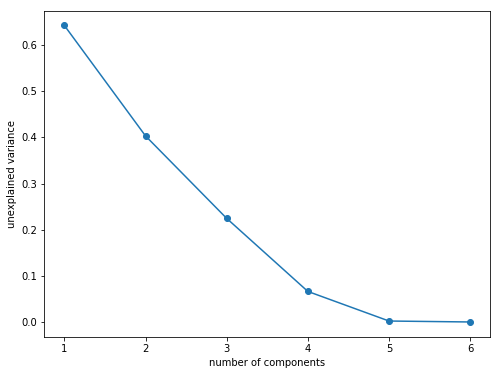

In [253]:
ethnic = list(ehtnicity_imp.columns.values)
ethnic.remove('Id2')
# Separating ethnicity
ehtnicity_imp_x = ehtnicity_imp.loc[:, ethnic].values
# Separating Id
ehtnicity_imp_y = ehtnicity_imp.loc[:,['Id2']].values

ehtnicity_imp_stand = StandardScaler().fit_transform(ehtnicity_imp_x)

plt.figure(figsize=(8,6))
    
# X-axis: number of PCA components
# Y-axis: amount of variance explained by different number of components
explained_var_plot(ehtnicity_imp_stand,6)
plt.xlabel('number of components')
plt.ylabel('unexplained variance')
plt.xticks(np.arange(1, 7, step=1))

In [254]:
pca_ethnic = PCA(n_components=4)
principalComponents_ethnic = pca_ethnic.fit_transform(ehtnicity_imp_stand)
principalDf_ethnic = pd.DataFrame(data = principalComponents_ethnic, columns = ['ethnic1','ethnic2',
                                                                                'ethnic3','ethnic4'])

finalPCA_ethnic = pd.concat([principalDf_ethnic, ethnicity['Id2']], axis = 1)
finalPCA_ethnic = finalPCA_ethnic.set_index('Id2').reset_index()
finalPCA_ethnic.head()

,Id2,ethnic1,ethnic2,ethnic3,ethnic4
0,02020,2.046710,1.966324,1.414919,1.814038
1,02090,0.008663,0.390996,1.508195,0.991148
2,02170,-1.292406,0.368015,1.016599,0.908852
3,01003,-1.028787,-0.173406,-0.225520,0.311329
4,01015,-0.521541,0.051559,-0.131472,0.060394


In [255]:
'''
fig = plt.figure(figsize=(20, 20))

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,resolution="l",
        projection='lcc',lat_1=40,lat_2=45,lon_0=-95)

#https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html
shp_info = m.readshapefile('/Users/matej/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k','states',drawbounds=True)

i,j = m(master.lon.tolist(), master.lat.tolist())

m.scatter(master.lon.tolist(), master.lat.tolist(),latlon=True,
          marker='o', alpha=.7, c=master.percent_no_internet.tolist(),
          s=200,cmap='Reds',zorder=10)
        
plt.colorbar(fraction=0.02, pad=0.04,label='% of people without internet')

#add hawaii and alaska

'''

'\nfig = plt.figure(figsize=(20, 20))\n\n# Lambert Conformal map of lower 48 states.\nm = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,resolution="l",\n        projection=\'lcc\',lat_1=40,lat_2=45,lon_0=-95)\n\n#https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html\nshp_info = m.readshapefile(\'/Users/matej/Desktop/cb_2016_us_state_500k/cb_2016_us_state_500k\',\'states\',drawbounds=True)\n\ni,j = m(master.lon.tolist(), master.lat.tolist())\n\nm.scatter(master.lon.tolist(), master.lat.tolist(),latlon=True,\n          marker=\'o\', alpha=.7, c=master.percent_no_internet.tolist(),\n          s=200,cmap=\'Reds\',zorder=10)\n        \nplt.colorbar(fraction=0.02, pad=0.04,label=\'% of people without internet\')\n\n#add hawaii and alaska\n\n'

In [256]:
master_final = pd.merge(master, finalPCA_ethnic, on='Id2')

In [257]:
master_final.columns

Index(['county', 'state_code', 'GEOID', 'lon', 'lat', 'P_total', 'P_white', 'P_black', 'P_asian', 'P_native', 'P_hawaiian', 'P_others', 'P_below_middle_school', 'P_some_high_school', 'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above', 'P_below_poverty', 'median_age', 'gini_index', 'median_household_income', 'median_rent_per_income', 'percent_no_internet', 'state_name', 'region', 'division', 'Id2', 'with_disability', 'employment_rate', 'unemployment_rate', 'male', 'female',
       'native_p_per', 'foreign_born_p_per', 'ethnicity', 'white_per', 'black_per', 'asian_per', 'native_per', 'hawaiian_per', 'others_per', 'edu', 'below_middle_school_per', 'some_high_school_per', 'high_school_per', 'some_college_per', 'bachelor_and_above_per', 'below_poverty_per', 'education_level', 'state_median_no_net', '25000_34999', '35000_49999', '50000_74999', '75000_99999', '100000_149999', 'text', 'no_net_over_state_level', 'no_net_over_national_level', 'ethnic1', 'ethnic2',
       'ethni

In [258]:
master_final_lin = master_final[['lon', 'lat', 'P_total', 'P_white',
                                 'P_black', 'P_asian', 'P_native', 'P_hawaiian',
                                 'P_others', 'P_below_middle_school', 'P_some_high_school',
                                 'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above',
                                 'P_below_poverty', 'median_age', 'gini_index', 'median_household_income',
                                 'median_rent_per_income', 'percent_no_internet', 'with_disability',
                                 'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per', 
                                 'foreign_born_p_per', 'ethnicity', 'white_per',
                                 'black_per', 'asian_per', 'native_per', 'hawaiian_per', 'others_per', 
                                 'below_middle_school_per', 'some_high_school_per', 'high_school_per',
                                 'some_college_per', 'bachelor_and_above_per','below_poverty_per','education_level',
                                 'state_median_no_net','25000_34999', '35000_49999', '50000_74999', '75000_99999', '100000_149999',
                                 'no_net_over_state_level', 'no_net_over_national_level', 
                                 'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']]
master_final_lin = pd.DataFrame(imp.fit_transform(master_final_lin))
master_final_lin.columns=['lon', 'lat', 'P_total', 'P_white',
                          'P_black', 'P_asian', 'P_native', 'P_hawaiian',
                          'P_others', 'P_below_middle_school', 'P_some_high_school',
                          'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above',
                          'P_below_poverty', 'median_age', 'gini_index', 'median_household_income',
                          'median_rent_per_income', 'percent_no_internet', 'with_disability',
                          'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per',
                          'foreign_born_p_per', 'ethnicity', 'white_per','black_per', 'asian_per', 
                          'native_per', 'hawaiian_per', 'others_per', 
                          'below_middle_school_per', 'some_high_school_per', 'high_school_per',
                          'some_college_per', 'bachelor_and_above_per','below_poverty_per','education_level',
                          'state_median_no_net','25000_34999', '35000_49999', '50000_74999', '75000_99999', 
                          '100000_149999','no_net_over_state_level', 'no_net_over_national_level',
                          'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']
master_final_lin['median_household_income_log'] = np.log(master_final_lin.median_household_income)

In [259]:
master_final_new = master_final_lin[['lon', 'lat', 'P_total', 'median_age', 'gini_index',
                                     'median_household_income_log','median_rent_per_income', 'with_disability',
                                     'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per',
                                     'foreign_born_p_per', 'education_level','below_poverty_per',
                                     'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4','percent_no_internet']]
y_lin = master_final_new['percent_no_internet']

In [260]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=50)
Selector_f.fit(master_final_new,y_lin)
for n,s in zip(master_final_new.columns,Selector_f.scores_):
    print("F-score: %3.2f for feature %s " % (s,n))

F-score: 4.79 for feature lon 
F-score: 47.05 for feature lat 
F-score: 19.75 for feature P_total 
F-score: 3.89 for feature median_age 
F-score: 50.04 for feature gini_index 
F-score: 1036.92 for feature median_household_income_log 
F-score: 0.43 for feature median_rent_per_income 
F-score: 353.77 for feature with_disability 
F-score: 389.92 for feature employment_rate 
F-score: 174.87 for feature unemployment_rate 
F-score: 12.09 for feature male 
F-score: 12.09 for feature female 
F-score: 58.84 for feature native_p_per 
F-score: 58.84 for feature foreign_born_p_per 
F-score: 837.71 for feature education_level 
F-score: 609.42 for feature below_poverty_per 
F-score: 0.75 for feature ethnic1 
F-score: 48.36 for feature ethnic2 
F-score: 49.92 for feature ethnic3 
F-score: 30.72 for feature ethnic4 
F-score: -1841972247594533632.00 for feature percent_no_internet 


In [261]:
X_lin = master_final_lin[['median_household_income_log',
                      'with_disability',
                      'employment_rate',
                      'education_level',
                      'below_poverty_per'
                     ]]
    
res_ols = sm.OLS(y_lin, sm.add_constant(X_lin)).fit()
print(res_ols.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.645
Model:                             OLS   Adj. R-squared:                  0.643
Method:                  Least Squares   F-statistic:                     295.5
Date:                 Fri, 13 Apr 2018   Prob (F-statistic):          3.81e-180
Time:                         23:14:22   Log-Likelihood:                 1583.8
No. Observations:                  820   AIC:                            -3156.
Df Residuals:                      814   BIC:                            -3127.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

In [262]:
var_ols = pd.concat([X_lin, y_lin], axis = 1)
var_ols.corr()

,median_household_income_log,with_disability,employment_rate,education_level,below_poverty_per,percent_no_internet
median_household_income_log,1.000000,-0.680126,0.663580,0.679614,-0.810405,-0.747670
with_disability,-0.680126,1.000000,-0.714781,-0.573823,0.428323,0.549463
employment_rate,0.663580,-0.714781,1.000000,0.587633,-0.542363,-0.568158
education_level,0.679614,-0.573823,0.587633,1.000000,-0.536842,-0.711303
below_poverty_per,-0.810405,0.428323,-0.542363,-0.536842,1.000000,0.653406
percent_no_internet,-0.747670,0.549463,-0.568158,-0.711303,0.653406,1.000000


In [263]:
master_lin_resampled = sklearn.utils.resample(master_final_new)

X_lin_sel = master_lin_resampled[['median_household_income_log',
                      'with_disability',
                      'employment_rate',
                      'education_level',
                      'below_poverty_per'
                     ]]

y_lin_sel = master_lin_resampled['percent_no_internet']

X_train, X_test, y_train, y_test = train_test_split(X_lin_sel, y_lin_sel, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(656, 5) (656,)
(164, 5) (164,)


Score: 0.6657344515538326


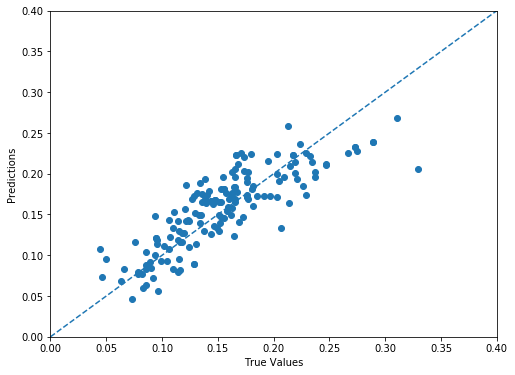

In [264]:
# Making predictions
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# The line / model
plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions)
plt.plot([0, 0.4], [0, 0.4],'--')
plt.xlim([0.0, 0.4])
plt.ylim([0.0, 0.4])
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", model.score(X_test, y_test))

In [298]:
scores = cross_val_score(lm, X_train, y_train, cv=10)

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.72401398 0.67155494 0.58424861 0.69213742 0.63135754 0.62499033
 0.61193823 0.65477916 0.58548062 0.66283697]
Mean: 0.6443337807147761
Standard deviation: 0.04300294481273013


In [299]:
'''
X1 = master_final_lin[['median_household_income_log',
                      #'with_disability',
                      #'employment_rate',
                      'education_level',
                      #'below_poverty_per'  # potentially take out?
                     ]]

res_ols1 = sm.OLS(y_lin, sm.add_constant(X1)).fit()
print(res_ols1.summary())
'''

"\nX1 = master_final_lin[['median_household_income_log',\n                      #'with_disability',\n                      #'employment_rate',\n                      'education_level',\n                      #'below_poverty_per'  # potentially take out?\n                     ]]\n\nres_ols1 = sm.OLS(y_lin, sm.add_constant(X1)).fit()\nprint(res_ols1.summary())\n"

In [300]:
master_log = master_final_lin[['lon', 'lat', 'P_total', 'median_age', 'gini_index',
                              'median_household_income_log','median_rent_per_income', 'with_disability',
                              'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per',
                              'foreign_born_p_per', 'education_level','below_poverty_per',
                              'ethnic1','ethnic2', 'ethnic3', 'ethnic4','no_net_over_national_level']]

master_log_resampled = sklearn.utils.resample(master_log)

In [301]:
X_log = master_log_resampled[['lon', 'lat', 'P_total', 'median_age', 'gini_index',
                              'median_household_income_log','median_rent_per_income', 'with_disability',
                              'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per',
                              'foreign_born_p_per', 'education_level','below_poverty_per',
                              'ethnic1','ethnic2', 'ethnic3', 'ethnic4']]
y_log = master_log_resampled['no_net_over_national_level']

# Feature selection
logreg = LogisticRegression()
rfe = RFE(logreg, 4)
rfe = rfe.fit(X_log,y_log)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False False
  True False  True  True False False False False]
[16 14 17 13  1  6 15  2  4  7  8  3  1  5  1  1 10  9 12 11]


In [302]:
# Keep variables 'gini_index','native_p_per','education_level' and 'below_poverty_per'
X_log_sel = master_log_resampled[['gini_index','native_p_per','education_level','below_poverty_per']]
result_log = sm.Logit(y_log,X_log_sel).fit()
print(result_log.summary())

Optimization terminated successfully.
         Current function value: 0.401746
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     no_net_over_national_level   No. Observations:                  820
Model:                                  Logit   Df Residuals:                      816
Method:                                   MLE   Df Model:                            3
Date:                        Fri, 13 Apr 2018   Pseudo R-squ.:                  0.4197
Time:                                23:16:39   Log-Likelihood:                -329.43
converged:                               True   LL-Null:                       -567.68
                                                LLR p-value:                5.939e-103
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
gini_index           27.1886  

In [303]:
# Fitting the Logit model
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_sel, y_log,
                                                                    test_size=0.2)

logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [304]:
y_pred_log = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test_log)))

Accuracy of logistic regression classifier on test set: 0.85


In [305]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results_logit = model_selection.cross_val_score(modelCV, X_train_log, y_train_log, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results_logit.mean()))

10-fold cross validation average accuracy: 0.802


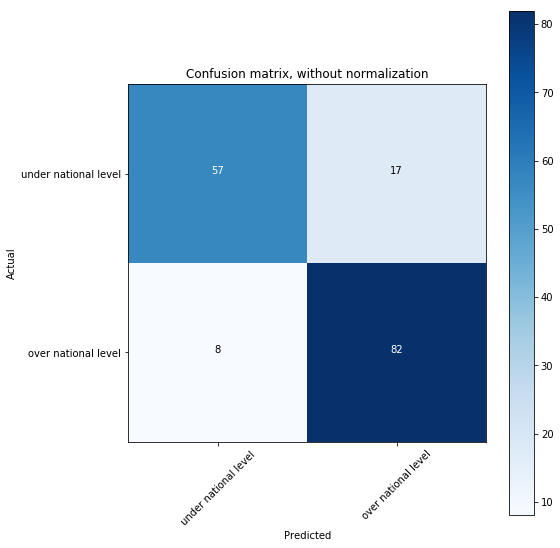

In [306]:
confusion_matrix_log = confusion_matrix(y_test_log, y_pred_log)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
class_names=["under national level","over national level"]    
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix_log, classes=class_names,
                      title='Confusion matrix, without normalization')


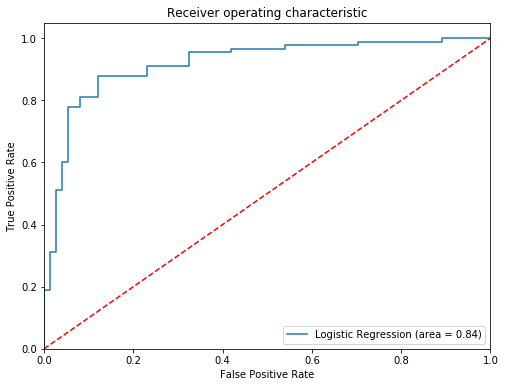

In [307]:
logit_roc_auc = roc_auc_score(y_test_log, logreg.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test_log, logreg.predict_proba(X_test_log)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [353]:
# have a closer look at top 10 counties with highest 'percent_no_internet'
master[['county','state_code','Id2','percent_no_internet']].sort_values(by='percent_no_internet',ascending=False).head(10)

,county,state_code,Id2,percent_no_internet
35,Apache County,AZ,04001,0.540114
480,McKinley County,NM,35031,0.468122
432,Robeson County,NC,37155,0.430978
391,Jones County,MS,28067,0.390185
729,Webb County,TX,48479,0.367418
40,Navajo County,AZ,04017,0.360020
483,San Juan County,NM,35045,0.334648
288,St. Landry Parish,LA,22097,0.334169
706,Jefferson County,TX,48245,0.329161
28,Jefferson County,AR,05069,0.319888


In [458]:
top10 = master.loc[
    master['Id2'].str.contains('04001') | 
    master['Id2'].str.contains('35031') |
    master['Id2'].str.contains('37155') |
    master['Id2'].str.contains('05069') |
    master['Id2'].str.contains('28067') |
    master['Id2'].str.contains('48479') |
    master['Id2'].str.contains('04017') |
    master['Id2'].str.contains('35045') |
    master['Id2'].str.contains('22097') |
    master['Id2'].str.contains('48245')]

In [459]:
top10 = top10[['county', 'state_code',
'median_household_income',
'with_disability',
'employment_rate',
'education_level',
'gini_index',
'native_p_per',
'below_poverty_per',
              'percent_no_internet']]

top10['county_state'] = top10['county'] + ", " + top10['state_code']

top10 = top10.drop(['county','state_code'],axis=1)
top10 = top10.set_index('county_state')

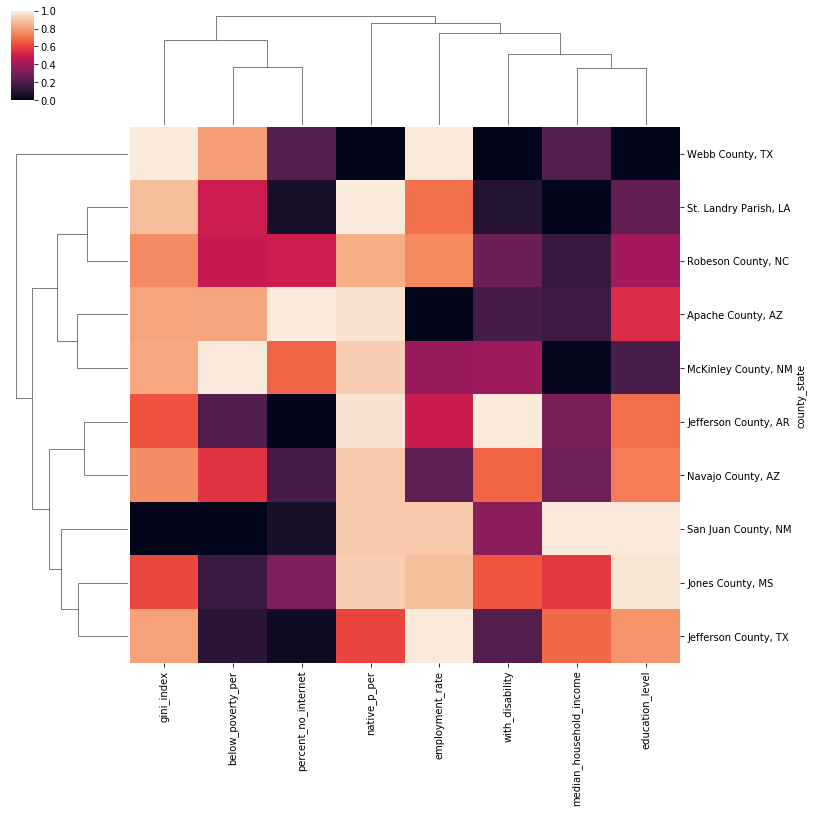

In [464]:
sns.clustermap(top10, robust=False, standard_scale=1, figsize=(12,12))